# SPARK Dataset


In [16]:
from spark_utils import PyTorchSparkDataset
from matplotlib import pyplot as plt
from random import randint

In [17]:
import torch
import torchvision

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`.

In [18]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2

class PyTorchSparkDatasetV2(torch.utils.data.Dataset):

    def __init__(self, class_map, split='train', root_dir='', transform=None, detection=True):
        super().__init__()
        self.dataset = PyTorchSparkDataset(class_map, split=split, root_dir=root_dir, transform=transform, detection=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label, bbox = self.dataset[idx]

        image = torchvision.tv_tensors.Image(image)
        label = torch.tensor([label])
        bbox = torchvision.tv_tensors.BoundingBoxes(bbox,
                                                    format = torchvision.tv_tensors.BoundingBoxFormat.XYXY, 
                                                    canvas_size=image.size)

        target = {'boxes': bbox, 'labels': label}
        return image, target

In [19]:
from torchvision.transforms import v2 as T
from torchvision import models, datasets, tv_tensors

# Define the transforms to be applied to the data.
def get_transform(is_train):
    transforms = []
    transforms.append(T.ToImage())

    # TODO: Add your own transformations for the train set here.
    
    # if is_train:
        # transforms.append(T.RandomPhotometricDistort(p = 0.5))
        # transforms.append(T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}))
        # transforms.append(T.RandomIoUCrop())
        # transforms.append(T.RandomHorizontalFlip(p = 0.5))
        # transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)


In [20]:
def get_dataset(is_train, class_map, data_path):

    split = "train" if is_train else "validation"

    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(class_map=class_map, 
                                    split=split, 
                                    root_dir=data_path, 
                                    transform=get_transform(is_train))

    return dataset

In [26]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = './data/'

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {'proba_2':0, 'cheops':1, 'debris':2, 'double_star':3, 'earth_observation_sat_1':4, 'lisa_pathfinder':5,
                        'proba_3_csc' :6, 'proba_3_ocs':7, 'smart_1':8, 'soho':9, 'xmm_newton':10}

# Define the number of classes
num_classes = len(class_map)

# Define the datasets for training and validation.
dataset = get_dataset(is_train=True, class_map=class_map, data_path=data_path)
dataset_valid = get_dataset(is_train=False, class_map=class_map, data_path=data_path)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")


Number of training samples: 66000
Number of validation samples: 22000



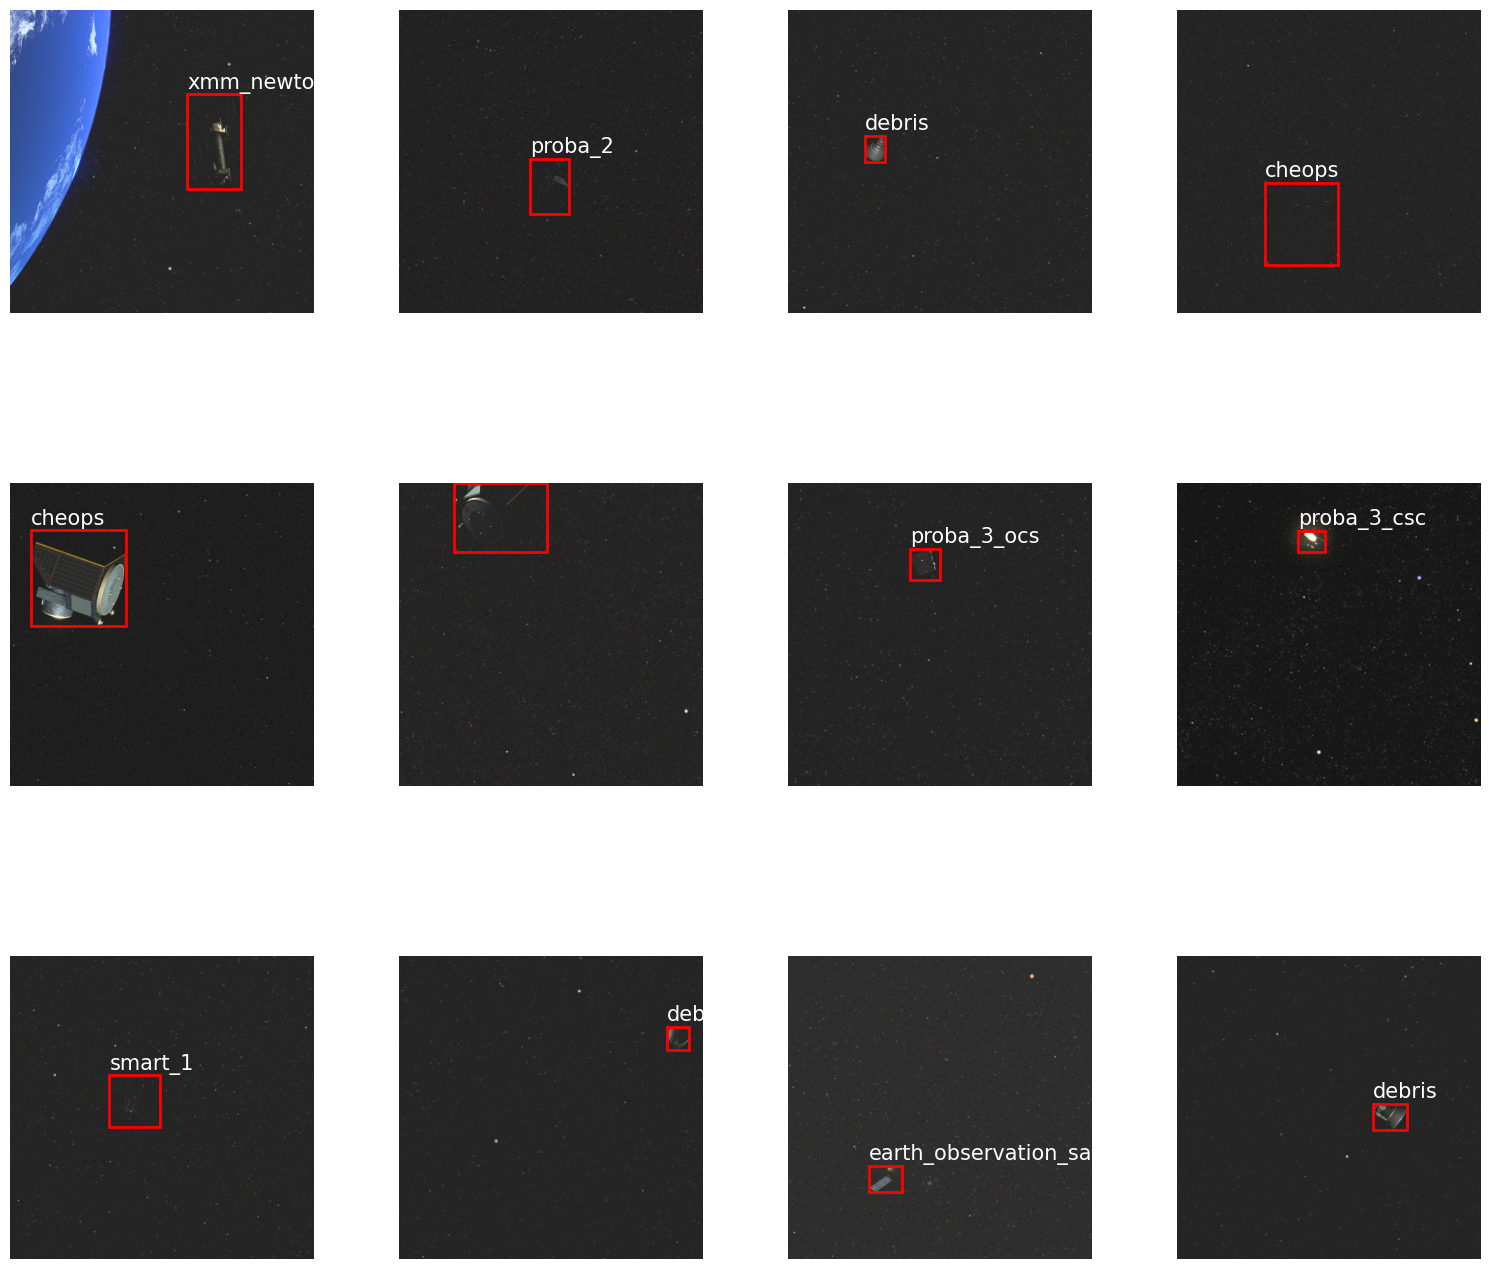

In [39]:
from spark_utils import SPARKDataset

rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

ds = SPARKDataset(class_map, root_dir=data_path,split='train')

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(dataset)),
                     size=(10,10),
                     ax=axes[i][j])
        axes[i][j].axis('off')

fig.tight_layout()

In [22]:
# Define the batch size to be used.
batch_size = 10


# Define the dataloaders for training and validation.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

In [23]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")


Image type: <class 'torchvision.tv_tensors._image.Image'>
Image shape: torch.Size([3, 1024, 1024])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels']

Boxes type: <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


In [24]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate

# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)